In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import os

def cargar_espectro(nombre_archivo, ruta="./drive/MyDrive/ProgramasTFM/Datos/Mezclas_XGGG", eliminar_rango=(1900, 4000)):
    df = pd.read_csv(os.path.join(ruta, nombre_archivo), header=None, delimiter=";")
    df.columns = ['wavenumber', 'absorbance']
    df.loc[(df['wavenumber'] > eliminar_rango[0]), 'absorbance'] = 0
    return df


## Calibrar con todos menos uno

In [3]:
guar = cargar_espectro('GUAR_E-412_TRAT.CSV')
guar_rep = cargar_espectro('GUAR_E-412_REP_TRAT.CSV')
xant = cargar_espectro('XANTANA_E-415_TRAT.CSV')
xant_rep = cargar_espectro('XANTANA_E-415_REP_TRAT.CSV')
mezcla1 = cargar_espectro('XANTANA10GUAR90_TRAT.CSV')
mezcla1_rep2 = cargar_espectro('XANTANA10GUAR90_REP2.CSV')
mezcla2 = cargar_espectro('XANTANA20GUAR80_TRAT.CSV')
mezcla2_rep = cargar_espectro('XANTANA20GUAR80_REP.CSV')
mezcla3 = cargar_espectro('XANTANA35GUAR65_TRAT.CSV')
mezcla3_rep = cargar_espectro('XANTANA35GUAR65_REP.CSV')
mezcla4 = cargar_espectro('XANTANA50GUAR50_TRAT.CSV')
mezcla4_rep2 = cargar_espectro('XANTANA50GUAR50_REP2.CSV')
mezcla5 = cargar_espectro('XANTANA65GUAR35_TRAT.CSV')
mezcla5_rep = cargar_espectro('XANTANA65GUAR35_REP.CSV')
mezcla6 = cargar_espectro('XANTANA80GUAR20_TRAT.CSV')
mezcla6_rep = cargar_espectro('XANTANA80GUAR20_REP.CSV')
mezcla6_rep2 = cargar_espectro('XANTANA80GUAR20_REP2.CSV')
mezcla7 = cargar_espectro('XANTANA90GUAR10_TRAT.CSV')
mezcla7_rep = cargar_espectro('XANTANA90GUAR10_REP.CSV')

In [5]:
wavenumbers = guar['wavenumber'].values

def interp_abs(df):
    return np.interp(wavenumbers, df['wavenumber'], df['absorbance'])

X_calibrado = np.vstack([
    interp_abs(guar),
    interp_abs(guar_rep),
    interp_abs(xant),
    interp_abs(xant_rep),
    interp_abs(mezcla1),
    interp_abs(mezcla1_rep2),
    interp_abs(mezcla2),
    interp_abs(mezcla2_rep),
    interp_abs(mezcla3),
    interp_abs(mezcla3_rep),
    interp_abs(mezcla4),
    interp_abs(mezcla4_rep2),
    interp_abs(mezcla5),
    interp_abs(mezcla5_rep),
    interp_abs(mezcla6),
    interp_abs(mezcla6_rep2),
    interp_abs(mezcla7),
    interp_abs(mezcla7_rep)
])

y_calibrado = [
    [1.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0],
    [0.9, 0.1],
    [0.9, 0.1],
    [0.8, 0.2],
    [0.8, 0.2],
    [0.65, 0.35],
    [0.65, 0.35],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.35, 0.65],
    [0.35, 0.65],
    [0.2, 0.8],
    [0.2, 0.8],
    [0.1, 0.9],
    [0.1, 0.9]
]

def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v / norm if norm != 0 else v

predicciones = []

for i in range(4,len(X_calibrado)):
  X_test = X_calibrado[i]
  y_test = y_calibrado[i]
  X_train = [x for j, x in enumerate(X_calibrado) if j != i]
  y_train = [y for j, y in enumerate(y_calibrado) if j != i]

  X_cal_norm = np.array([normalize_vector(x) for x in X_train])
  X_test_norm = normalize_vector(X_test).reshape(1, -1)

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X_cal_norm)

  pls = PLSRegression(n_components=3)
  pls.fit(X_scaled, y_train)

  X_real_scaled = scaler.transform(X_test_norm)

  preds = pls.predict(X_real_scaled)
  preds = np.clip(preds, 0, None)  # mínimo 0
  preds_sum = preds.sum(axis=1).reshape(-1, 1)
  preds_norm = preds / preds_sum  # normaliza para que sumen 1

  predicciones.append(preds_norm)

In [6]:
grupos = [
    "guar", "guar",
    "xant", "xant",
    "mezcla10", "mezcla10",
    "mezcla20", "mezcla20",
    "mezcla35", "mezcla35",
    "mezcla50", "mezcla50",
    "mezcla65", "mezcla65",
    "mezcla80", "mezcla80",
    "mezcla90", "mezcla90"
]

predicciones = []
grupos_predichos = []
y_real = []

for i in range(len(X_calibrado)):
    grupo_actual = grupos[i]

    if grupo_actual in ["guar", "xant"]:
        continue

    X_train = [x for j, x in enumerate(X_calibrado) if grupos[j] != grupo_actual]
    y_train = [y for j, y in enumerate(y_calibrado) if grupos[j] != grupo_actual]

    X_test = X_calibrado[i]
    y_test = y_calibrado[i]

    X_cal_norm = np.array([normalize_vector(x) for x in X_train])
    X_test_norm = normalize_vector(X_test).reshape(1, -1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cal_norm)
    X_real_scaled = scaler.transform(X_test_norm)

    pls = PLSRegression(n_components=3)
    pls.fit(X_scaled, y_train)
    preds = pls.predict(X_real_scaled)
    preds = np.clip(preds, 0, None)
    preds_norm = preds / preds.sum(axis=1, keepdims=True)

    predicciones.append(preds_norm)
    grupos_predichos.append(grupo_actual)
    y_real.append(y_test)

predicciones

[array([[0.85533974, 0.14466026]]),
 array([[0.91458864, 0.08541136]]),
 array([[0.81417096, 0.18582904]]),
 array([[0.80123516, 0.19876484]]),
 array([[0.61231472, 0.38768528]]),
 array([[0.60397455, 0.39602545]]),
 array([[0.49760816, 0.50239184]]),
 array([[0.52524326, 0.47475674]]),
 array([[0.3967363, 0.6032637]]),
 array([[0.41474376, 0.58525624]]),
 array([[0.15736419, 0.84263581]]),
 array([[0.2259782, 0.7740218]]),
 array([[0., 1.]]),
 array([[0.07823971, 0.92176029]])]

In [7]:
weights_squared = pd.DataFrame(
    pls.x_weights_**2,
    columns=[f'Componente {i+1}' for i in range(pls.x_weights_.shape[1])],
    index=wavenumbers
)

weights_squared = weights_squared.loc[(weights_squared.index >= 800) & (weights_squared.index <= 1800)]

def seleccionar_bandas(distancia_minima_cm1=20, top_n=5):
    bandas_por_componente = {}

    for comp in weights_squared.columns:
        serie = weights_squared[comp].sort_values(ascending=False)
        seleccionadas = []

        for wn, val in serie.items():
            if all(abs(wn - s) >= distancia_minima_cm1 for s in seleccionadas):
                seleccionadas.append(wn)
                if len(seleccionadas) == top_n:
                    break

        bandas_por_componente[comp] = pd.Series(
            {wn: weights_squared.loc[wn, comp] for wn in seleccionadas}
        )

    return bandas_por_componente

bandas_seleccionadas = seleccionar_bandas()

df_resultado = pd.concat(bandas_seleccionadas, axis=1).sort_index().reset_index()
df_resultado.columns = ['Wavenumber'] + list(bandas_seleccionadas.keys())

print(df_resultado)

    Wavenumber  Componente 1  Componente 2  Componente 3
0     848.5254           NaN           NaN      0.004441
1    1087.6550           NaN           NaN      0.005431
2    1118.5110           NaN           NaN      0.007115
3    1143.5810      0.002752           NaN           NaN
4    1226.5050           NaN      0.004081           NaN
5    1311.3570           NaN      0.006340           NaN
6    1344.1410           NaN      0.007242           NaN
7    1405.8520      0.002757           NaN           NaN
8    1590.9850      0.002772           NaN           NaN
9    1612.1980      0.002775           NaN           NaN
10   1656.5530           NaN           NaN      0.011026
11   1677.7660           NaN           NaN      0.004442
12   1718.2640      0.002744           NaN           NaN
13   1764.5470           NaN      0.005899           NaN
14   1791.5460           NaN      0.007132           NaN


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

y_real_array = np.array(y_real)
preds_array = np.array(predicciones).squeeze()

rmse_guar = mean_squared_error(y_real_array[:, 0], preds_array[:, 0])
rmse_xant = mean_squared_error(y_real_array[:, 1], preds_array[:, 1])

rmse_total = mean_squared_error(y_real_array, preds_array)

print("RMSECV guar:", rmse_guar)
print("RMSECV xantana:", rmse_xant)
print("RMSECV total:", rmse_total)

RMSECV guar: 0.0018523857130242247
RMSECV xantana: 0.0018523857130242232
RMSECV total: 0.001852385713024224


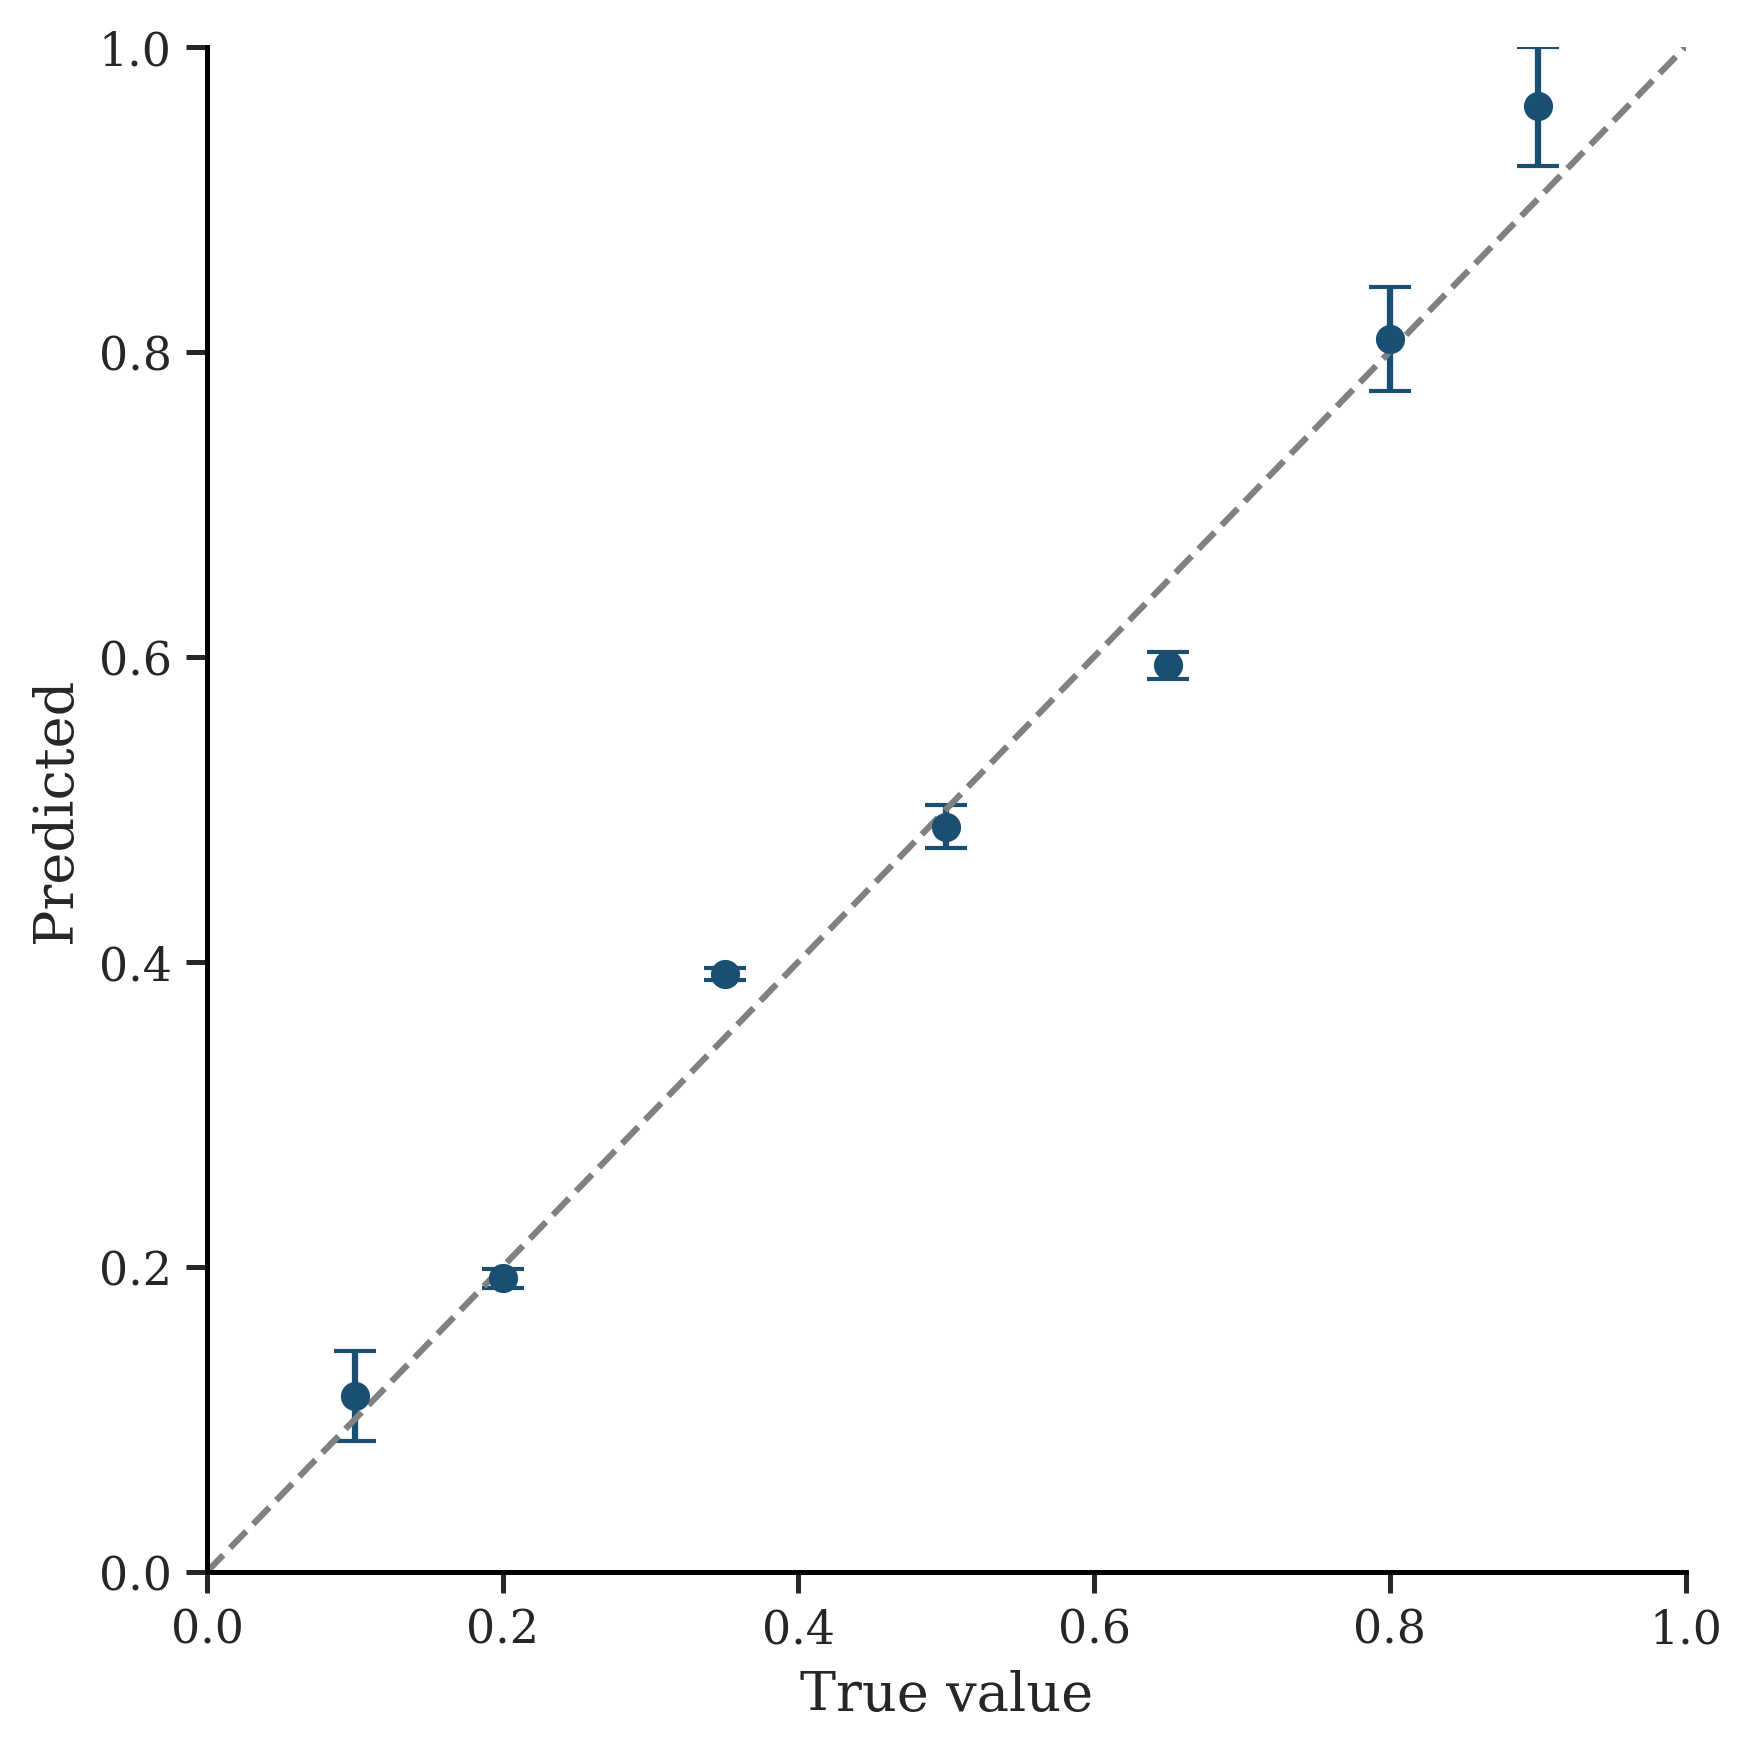

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager as font_manager

y_calibrado_array = np.array(y_calibrado)
xant_real = y_calibrado_array[4:,1]
pred_array = np.array(predicciones).squeeze()
xant_pred = pred_array[:,1]

sns.set_style('whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12,
    'lines.linewidth': 1.5,
    'figure.dpi': 300,
    'pdf.fonttype': 42,
})

available_fonts = [f.name for f in font_manager.fontManager.ttflist]
if 'Times New Roman' in available_fonts:
    plt.rcParams['font.family'] = 'Times New Roman'
else:
    mpl.rcParams['font.family'] = 'serif'

predicciones_array = np.array(predicciones).squeeze()
grupos_pred = predicciones_array.reshape(-1, 2, 2)
media_pred_xant = grupos_pred[:, :, 1].mean(axis=1)
std_pred_xant = grupos_pred[:, :, 1].std(axis=1)

valores_reales_xant = np.array(y_calibrado[4::2])[:, 1]

r2 = r2_score(xant_real, xant_pred)

plt.figure(figsize=(6, 6))
plt.errorbar(valores_reales_xant, media_pred_xant, yerr=std_pred_xant,
             fmt='o', capsize=5, color='#1B4F72')

plt.plot([0, 1], [0, 1], '--', color='gray')

plt.xlabel('True value')
plt.ylabel('Predicted')

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.tick_params(
    direction='out',
    length=5,
    width=1.2,
    bottom=True, top=False,
    left=True, right=False
)

ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(False)
plt.tight_layout()

plt.savefig("PLS_FTIR_regression.png", dpi=600)
plt.show()

/tmp/ipython-input-4015729394.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


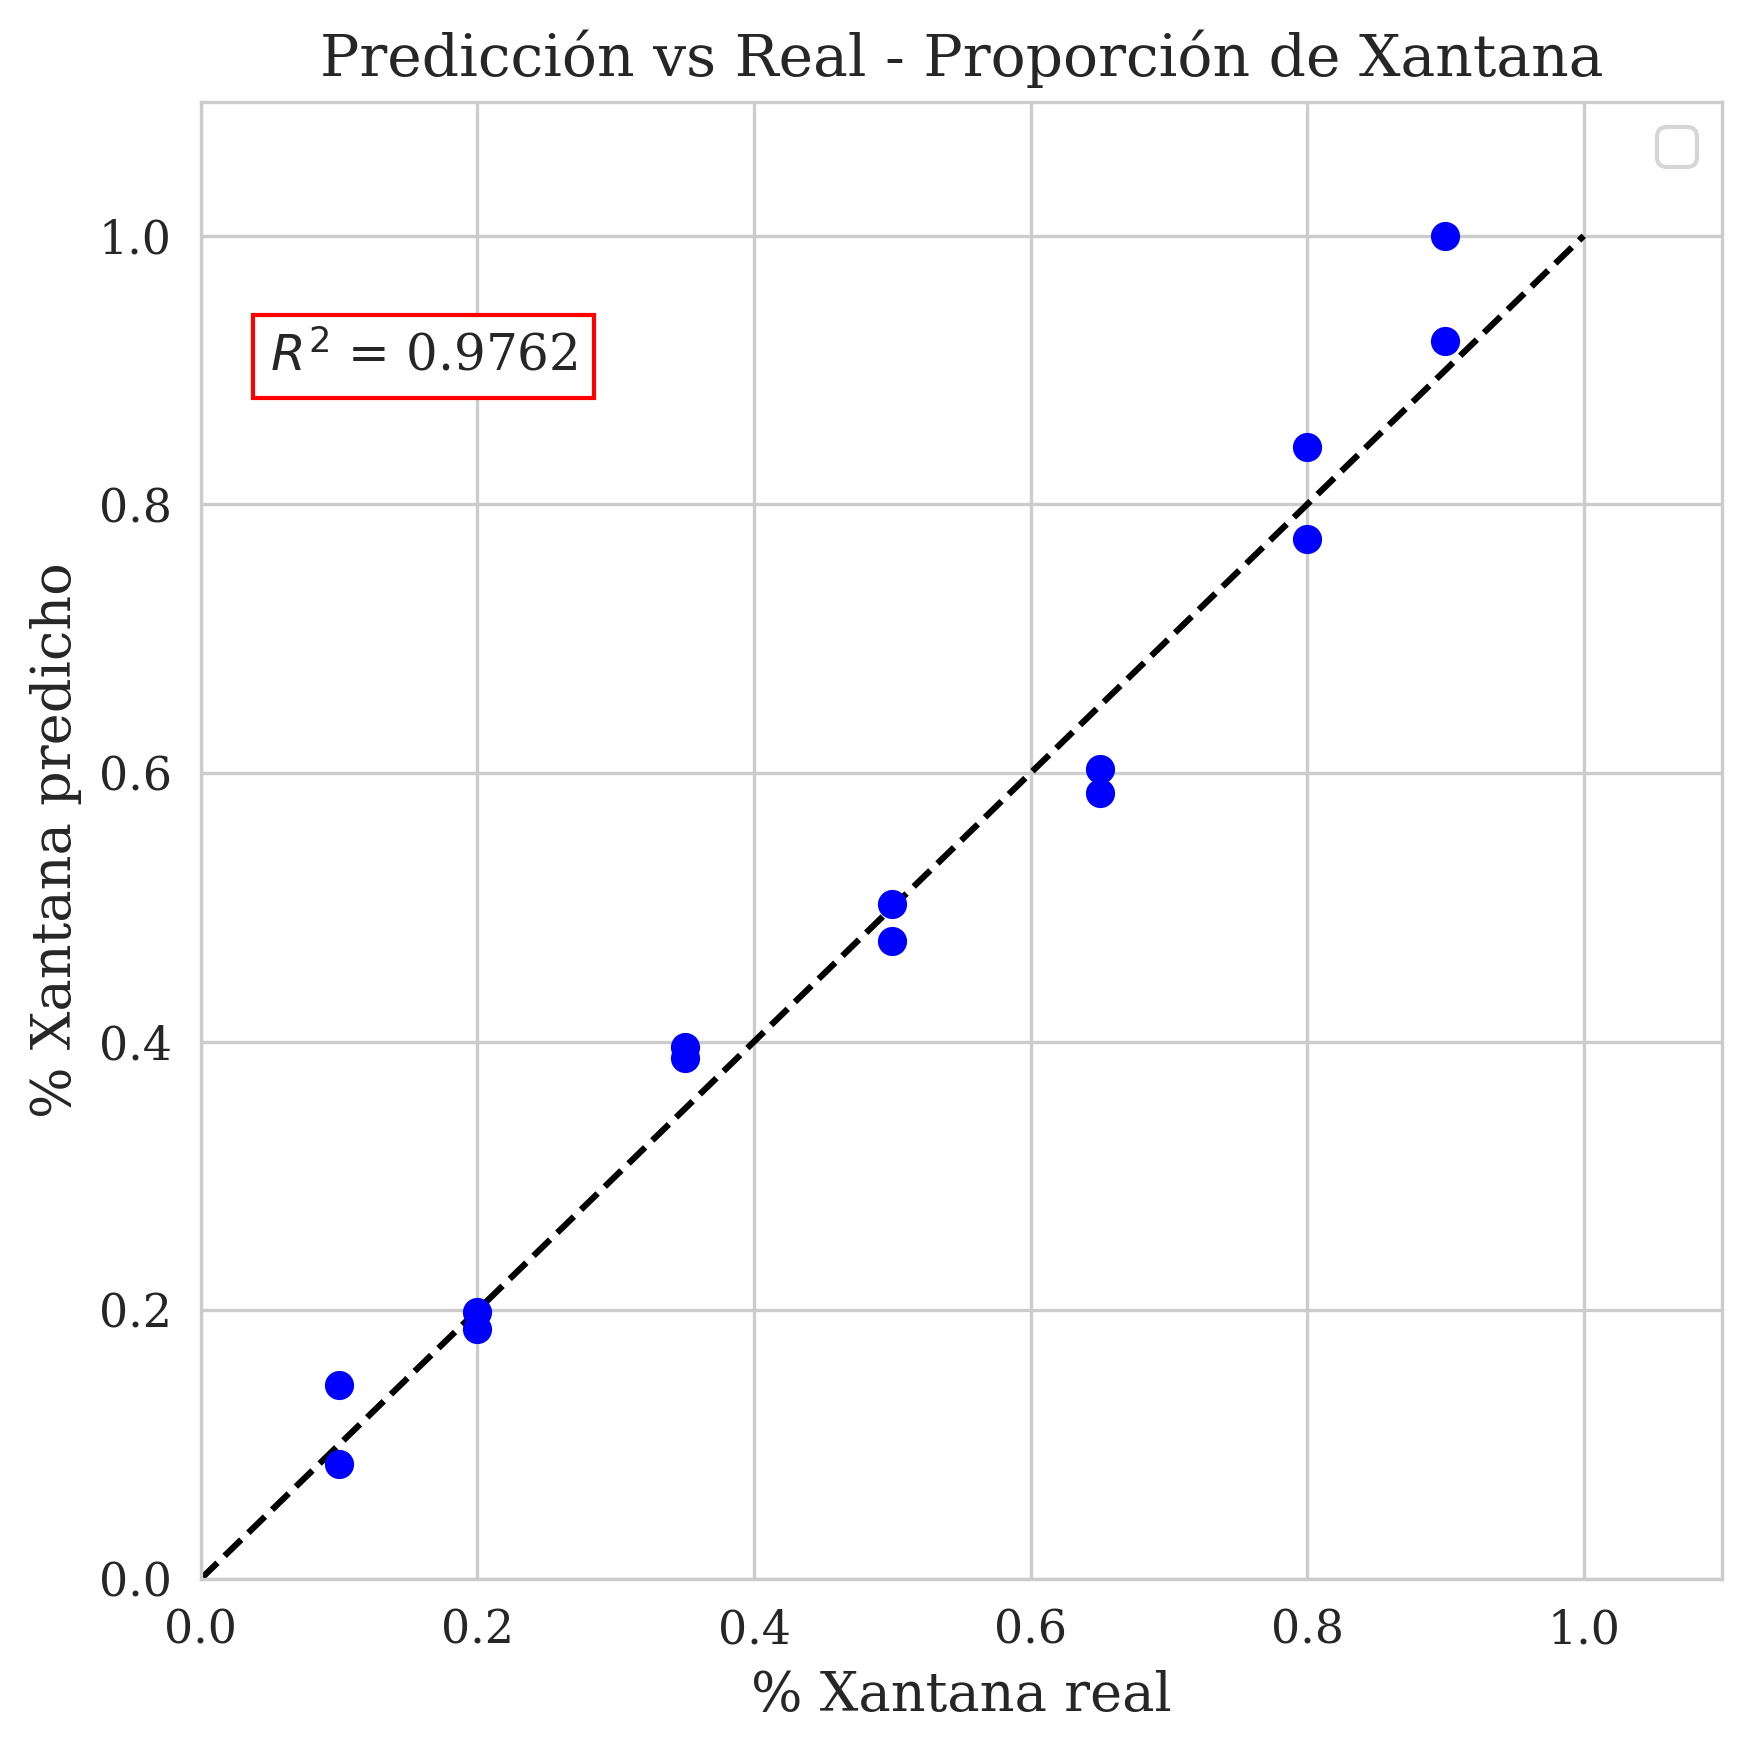

In [11]:
r2 = r2_score(xant_real, xant_pred)

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(xant_real, xant_pred, 'o', color='blue')

plt.xlabel("% Xantana real")
plt.ylabel("% Xantana predicho")
plt.title("Predicción vs Real - Proporción de Xantana")
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.text(0.05, 0.9, f"$R^2$ = {r2:.4f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='red'))
plt.legend()
plt.tight_layout()
plt.show()

## Muestras problema. Resultados no presentados en el TFM

**Mezclas problema**

In [ ]:
problema1rep = cargar_espectro('GUAR_XANTANA_3000260_REP_TRAT.CSV')
problema1 = cargar_espectro('GUAR_XANTANA_3000260_TRAT.CSV')
problema2rep = cargar_espectro('GUAR_XANTANA_HIDROSOL_REP_TRAT.CSV')
problema2 = cargar_espectro('GUAR_XANTANA_HIDROSOL_TRAT.CSV')
problema3rep = cargar_espectro('GUAR_XANTANA_INICIAL_REP_TRAT.CSV')
problema3 = cargar_espectro('GUAR_XANTANA_INICIAL_TRAT.CSV')

X_problema = np.vstack([
    interp_abs(problema1),
    interp_abs(problema1rep),
    interp_abs(problema2),
    interp_abs(problema2rep),
    interp_abs(problema3),
    interp_abs(problema3rep)
])

X_cal_norm = np.array([normalize_vector(x) for x in X_calibrado])
X_test_norm = np.array([normalize_vector(x) for x in X_problema])

# Escalado (media 0, varianza 1) sobre espectros simulados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cal_norm)

# Entrenar modelo PLS con 2 componentes (puedes probar 1 o 3)
pls = PLSRegression(n_components=1)
pls.fit(X_scaled, y_calibrado)

# Escalar datos reales con el mismo scaler
X_real_scaled = scaler.transform(X_test_norm)

# Predecir proporciones
preds = pls.predict(X_real_scaled)
preds = np.clip(preds, 0, None)  # mínimo 0
preds_sum = preds.sum(axis=1).reshape(-1, 1)
preds_norm = preds / preds_sum  # normaliza para que sumen 1


# Mostrar resultados con suma de proporciones
for i, p in enumerate(preds_norm):
    print(f"Mezcla {i+1}: Guar = {p[0]:.2f}, Xantana = {p[1]:.2f}, suma = {p.sum():.2f}")

Mezcla 1: Guar = 0.91, Xantana = 0.09, suma = 1.00
Mezcla 2: Guar = 0.88, Xantana = 0.12, suma = 1.00
Mezcla 3: Guar = 0.74, Xantana = 0.26, suma = 1.00
Mezcla 4: Guar = 0.77, Xantana = 0.23, suma = 1.00
Mezcla 5: Guar = 0.85, Xantana = 0.15, suma = 1.00
Mezcla 6: Guar = 0.91, Xantana = 0.09, suma = 1.00


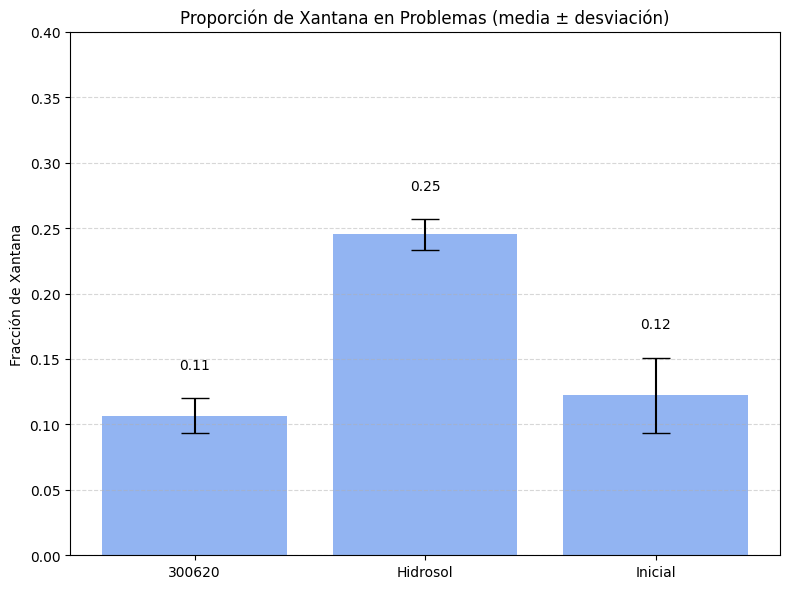

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Separar predicciones normalizadas para cada réplica
xantana_pred = preds_norm[:, 1].reshape(3, 2)  # 3 problemas, 2 réplicas cada uno

# Calcular media y desviación estándar para cada problema
xantana_mean = xantana_pred.mean(axis=1)
xantana_std = xantana_pred.std(axis=1)

problemas = ['300620', 'Hidrosol', 'Inicial']
x_pos = np.arange(len(problemas))

# Crear gráfico
plt.figure(figsize=(8, 6))
plt.bar(x_pos, xantana_mean, yerr=xantana_std, align='center', alpha=0.7, capsize=10, color='cornflowerblue')
plt.xticks(x_pos, problemas)
plt.ylabel('Fracción de Xantana')
plt.title('Proporción de Xantana en Problemas (media ± desviación)')

# Añadir valores arriba de cada barra
for i, (m, s) in enumerate(zip(xantana_mean, xantana_std)):
    plt.text(i, m + s + 0.02, f"{m:.2f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
